In [2]:
import sys
import os
import pandas as pd
import numpy as np
import generative_model
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

In [3]:
def process_data(input_data):
    data = input_data.copy()
    data['frame_id'] = pd.to_numeric(data['frame_id'], downcast='integer')
    data['track_id'] = pd.to_numeric(data['track_id'], downcast='integer')

    data['frame_id'] = data['frame_id'] // 10

    data['frame_id'] -= data['frame_id'].min()

    data['node_type'] = 'PEDESTRIAN'
    data['node_id'] = data['track_id'].astype(str)
    data.sort_values('frame_id', inplace=True)

    data['pos_x'] = data['pos_x'] - data['pos_x'].mean()
    data['pos_y'] = data['pos_y'] - data['pos_y'].mean()
    
    # Select only such nodes which have enough data to predict on (8 historical timesteps, 12 future)
    v = data.node_id.value_counts()
    data = data[data.node_id.isin(v.index[v.gt(19)])]
    
    return data

In [4]:
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def calculate_ADE(pred_x, pred_y, test_x, test_y):
    assert len(pred_x) == len(test_x)
    total_displacement_error = 0
    for point_idx in range(len(test_x)):
        displacement_error = np.sqrt((pred_x[point_idx] - test_x[point_idx])**2 + (pred_y[point_idx] - test_y[point_idx])**2)
        total_displacement_error += displacement_error

    return total_displacement_error/len(pred_x)

## The evaluation logic for Trajectron++ loops over the frames and predicts the future trajectories 
## for each node present in the current frame
## Each node has to have at least 7 historical points and 12 future points
def get_total_predictable_slices(data):
    total_predictable_steps = 0
    for i in pd.unique(data.node_id):
        #print(len(test[test.node_id == i]))
        total_predictable_steps += len(data[data.node_id == i]) - 19
    return total_predictable_steps

In [27]:
def plot_many_trajectories(sample_x, sample_y, gt_x, gt_y, pred_xs, pred_ys, annotations = [], finalize_plot = True):
    if finalize_plot:
        plt.figure(figsize=(10, 10))
        plt.axes().set_aspect('equal')
    
    plt.plot(sample_x, sample_y, c='green')
    plt.scatter(sample_x, sample_y, c='green')
    
    plt.plot(gt_x, gt_y, c='red')
    plt.scatter(gt_x, gt_y, c='red')
    
    plt.scatter(x_data[0], y_data[0], c='blue')
    
    #plt.plot(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    #plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    
    for i in range(len(pred_xs)):
        plt.plot(np.append(sample_x[-1], pred_xs[i]), np.append(sample_y[-1], pred_ys[i]), c='orange', linewidth=0.5)
        plt.scatter(pred_xs[i], pred_ys[i], c='orange', linewidth=0.25)
        if len(annotations) > 0:
            plt.annotate(annotations[i], (pred_xs[i][-1], pred_ys[i][-1]))
    
    if finalize_plot:
        plt.show()

In [6]:
data = pd.read_csv('./raw_data/zara1/test/crowds_zara01.txt', sep='\t', index_col=False, header=None)
data.columns = ['frame_id', 'track_id', 'pos_x', 'pos_y']
data = process_data(data)

In [33]:
data

,frame_id,track_id,pos_x,pos_y,node_type,node_id
0,0,1,6.359083,-0.959546,PEDESTRIAN,1
1,0,2,6.253850,-0.458360,PEDESTRIAN,2
2,0,3,4.822688,-0.458360,PEDESTRIAN,3
3,0,4,4.738502,0.257619,PEDESTRIAN,4
4,0,5,1.623618,-0.482226,PEDESTRIAN,5
...,...,...,...,...,...,...
5146,899,144,-6.317020,-0.478885,PEDESTRIAN,144
5150,900,147,-6.664288,0.073612,PEDESTRIAN,147
5151,900,148,-6.586205,1.292209,PEDESTRIAN,148
5149,900,144,-6.767836,-0.660744,PEDESTRIAN,144


In [8]:
zara1_params = {
    'NOISE': 0.05, 
    'NO_OF_TRAJECTORIES': 300, 
    'CONST_VEL_MODEL_PROB': 0.5, 
    'STOP_PROB': 0.05, 
    'DISCOUNT_AVG_PROB': 1.0, 
    'DISCOUNT_LOWER_BOUND': 0.2, 
    'VELOCITY_CHANGE_PROB': 0.2,
    'VELOCITY_CHANGE_NOISE': 0.1, 
    'ANGLE_CHANGE_PROB': 0.25, 
    'ANGLE_CHANGE_NOISE': 2.5, 
    'GROUP_PERCENTAGES': [0.1, 0.4, 0.65, 0.85, 1.0], 
    'GROUP_CLUSTER_COUNT': [1, 6, 5, 5, 3]
}

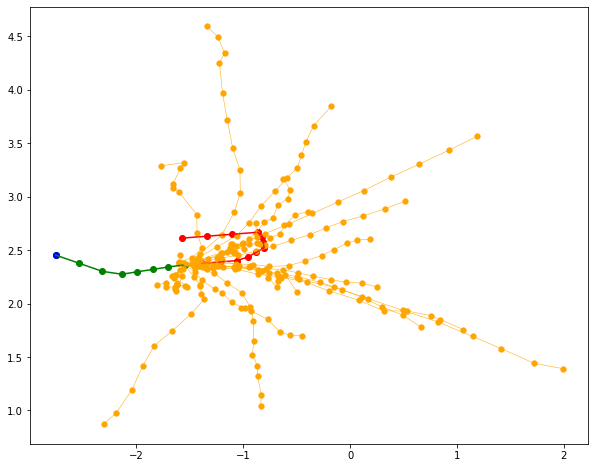

Best FDE:  0.4563886276100915
Best ADE:  0.2531592878117774


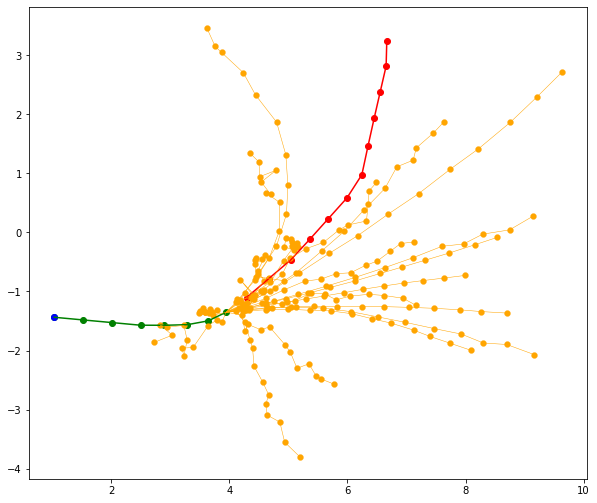

Best FDE:  1.6780517986682602
Best ADE:  0.6487732477522113


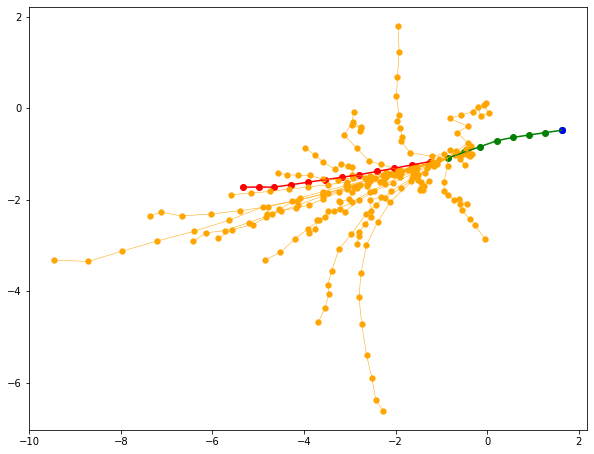

Best FDE:  0.3241017744198721
Best ADE:  0.1418153038706612


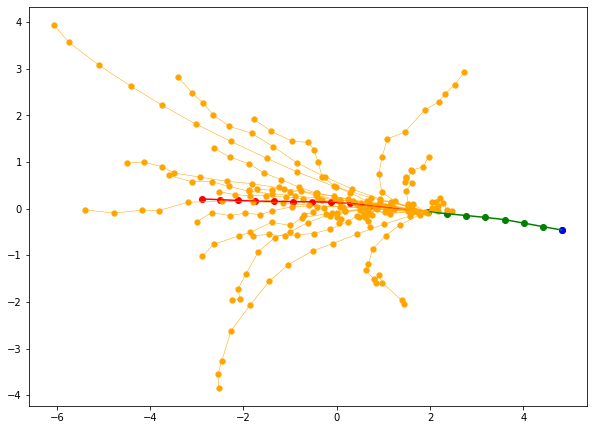

Best FDE:  0.3903098814467335
Best ADE:  0.22065694405465952


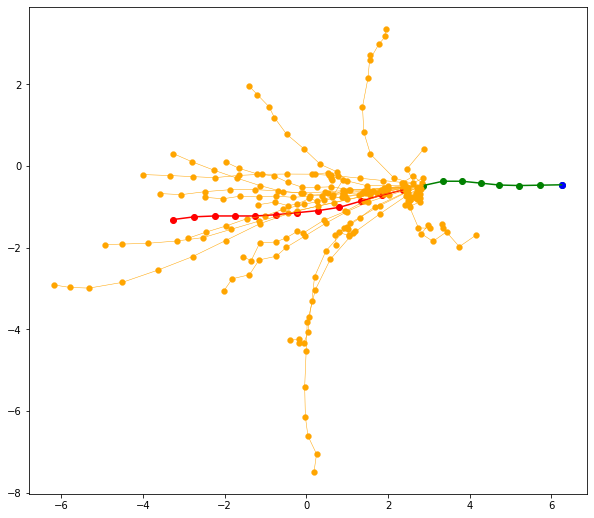

Best FDE:  0.5910090587175109
Best ADE:  0.2905224018561661


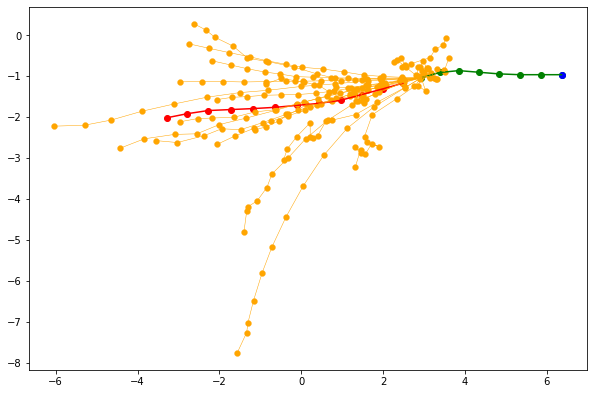

Best FDE:  0.32907987876387745
Best ADE:  0.15439045609211022


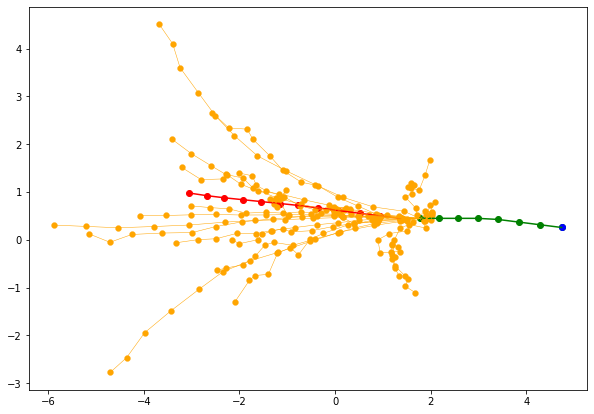

Best FDE:  0.27051213415145364
Best ADE:  0.1671143509877736


In [32]:
for frame_id in pd.unique(data.frame_id)[:8]:
    frame_data = data[data.frame_id == frame_id]
    for node_id in pd.unique(frame_data.node_id):
        if len(data[((data.node_id == node_id) & (data.frame_id <= frame_id))]) >= 8:
            if len(data[((data.node_id == node_id) & (data.frame_id > frame_id))]) >= 12:
                node_history_data = data[((data.node_id == node_id) & (data.frame_id <= frame_id) & (data.frame_id >= frame_id-7))]
                node_gt_data = data[((data.node_id == node_id) & (data.frame_id > frame_id) & (data.frame_id <= frame_id+12))]

                x_data = list(node_history_data.pos_x)
                y_data = list(node_history_data.pos_y)
                assert len(x_data) == 8

                x_gt = list(node_gt_data.pos_x)
                y_gt = list(node_gt_data.pos_y)
                assert len(x_gt) == 12

                all_pred_x, all_pred_y, _ = generative_model.predict(x_data, y_data, zara1_params, trajectory_length=12)
                assert len(all_pred_x[0]) == 12
                
                plot_many_trajectories(x_data, y_data, x_gt, y_gt, all_pred_x, all_pred_y)

                # This section is for finding the best trajectories out of many in terms of FDE and ADE
                best_fde = None
                best_ade = None

                for i in range(len(all_pred_x)):
                    current_pred_x = all_pred_x[i]
                    current_pred_y = all_pred_y[i]

                    fde = calculate_FDE(current_pred_x, current_pred_y, x_gt, y_gt)
                    if best_fde == None or fde < best_fde:
                        best_fde = fde

                    ade = calculate_ADE(current_pred_x, current_pred_y, x_gt, y_gt)
                    if best_ade == None or ade < best_ade:
                        best_ade = ade

                print("Best FDE: ", best_fde)
                print("Best ADE: ", best_ade)

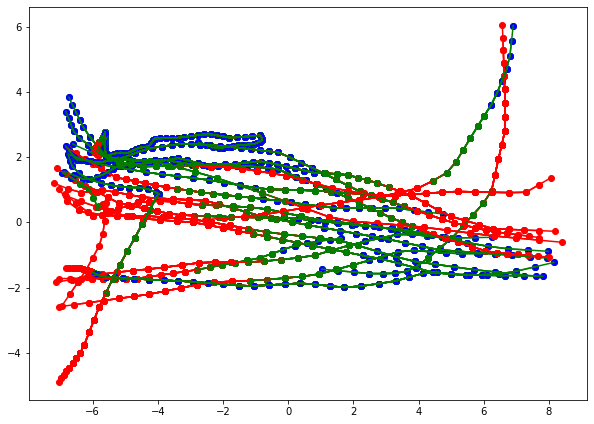

In [31]:
plt.figure(figsize=(10, 10))
plt.axes().set_aspect('equal')


for frame_id in pd.unique(data.frame_id)[:100]:
    frame_data = data[data.frame_id == frame_id]
    for node_id in pd.unique(frame_data.node_id):
        if len(data[((data.node_id == node_id) & (data.frame_id <= frame_id))]) >= 8:
            if len(data[((data.node_id == node_id) & (data.frame_id > frame_id))]) >= 12:
                node_history_data = data[((data.node_id == node_id) & (data.frame_id <= frame_id) & (data.frame_id >= frame_id-7))]
                node_gt_data = data[((data.node_id == node_id) & (data.frame_id > frame_id) & (data.frame_id <= frame_id+12))]

                x_data = list(node_history_data.pos_x)
                y_data = list(node_history_data.pos_y)

                x_gt = list(node_gt_data.pos_x)
                y_gt = list(node_gt_data.pos_y)
                
                plot_many_trajectories(x_data, y_data, x_gt, y_gt, [], [], finalize_plot=False)
plt.show()
